In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
tf.autograph.set_verbosity(0)
from tensorflow.keras import datasets, models, layers
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install --upgrade tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from zmq.constants import CHANNEL
# initialize our constants

IMAGE_SIZE = (64) #lets resize the images are of equal size;
BATCH_SIZE = 32
CHANNELS = 3

from PIL import Image

# Set the desired size of the images
#target_size = (224, 224)  # Or any other desired size

# Loop through each image in the dataset
#for i in range(10015):
    # Load the image using PIL
    #image = Image.open(f'./ham10000_images_part_1/{i}.jpg')
    
    # Resize the image
    #image = image.resize(target_size)
    
    # Save the resized image to a new file
   # image.save(f'./resized_images/{i}.jpg')


In [5]:
#folder = 'drive//MyDrive//Colab Notebooks//Neu_comp_dataverse_files_1//'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab_files/Neu_Comp/dataverse_files',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 21541 files belonging to 3 classes.


In [6]:
#declare the class_names

class_names = dataset.class_names
class_names
#['akiec', 'bcc', 'bkl', 'df', 'mel',
#'nv', 'vasc']

['HAM10000_data',
 'HAM10000_segmentations_lesion_tschandl',
 'ISIC2018_Task3_Test_Images']

In [7]:
len(dataset)

674

In [8]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 64, 64, 3)
[1 2 1 2 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 2 1 0 0 1]


In [9]:
#Lets print the first image
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy())

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [10]:
#lets show the shape of the first image
print(image_batch[0].shape)

(64, 64, 3)


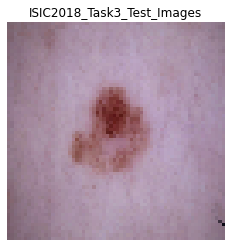

In [11]:
#lets visualize the first image

for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[label_batch[0]])
  plt.axis("off")

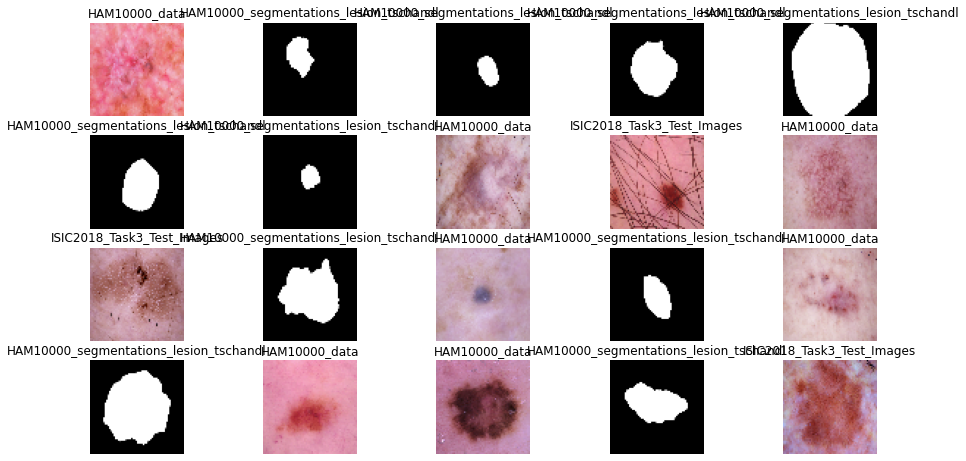

In [12]:
#lets show a range of 12 images from the dataset

plt.figure(figsize=(15, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
      ax = plt.subplot(5, 5, i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

In [13]:
len(dataset)

674

In [14]:
from tensorflow.python import training
#let split our dataset into train, validation and test set
#80% == training, #20% == 10% validation, 10% test

train_size = 0.8   #80% == training
len(dataset)*train_size

539.2

In [15]:
#this seperates the train_set
train_set = dataset.take(538)
len(train_set)

538

In [16]:
#this sepeartes the remaining part
test_set = dataset.skip(538)
len(test_set)

136

In [17]:
val_size = 0.1  #actual validation set size
len(dataset)*val_size

val_set = test_set.take(67)  #this seperates the validation set
len(val_set)

67

In [18]:
#this seperates the test_set

test_set =  test_set.skip(67)
len(test_set)

69

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size= 10000):
    ds_size = len(ds)

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
#confirm the size of the train_set, valiadation_set and test_set

len(train_ds)



539

In [22]:
len(val_ds)

67

In [23]:
len(test_ds)

68

In [24]:
#optimizing the dataset for the training process

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#preprocessing - scale the images by dividing it by 255

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [26]:
#apply some data augmentation in order have a very roburst model

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [27]:
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import itertools

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7, activation='softmax'))

In [28]:

#input_shape = (IMAGE_SIZE, IMAGE_SIZE, BATCH_SIZE, CHANNELS)

#model = models.Sequential()
#model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation='relu', input_shape=(64,64,3)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(256, (3,3), activation='relu'))
#model.add(layers.MaxPooling2D(2,2))
#model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(7, activation='softmax'))


In [29]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)       

In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
539/539 [==============================] - 1908s 675ms/step - loss: 1.2621 - accuracy: 0.9139 - val_loss: 0.2292 - val_accuracy: 0.9277
Epoch 2/50
539/539 [==============================] - 229s 424ms/step - loss: 0.2280 - accuracy: 0.9285 - val_loss: 0.2156 - val_accuracy: 0.9282
Epoch 3/50
539/539 [==============================] - 230s 426ms/step - loss: 0.2247 - accuracy: 0.9286 - val_loss: 0.2337 - val_accuracy: 0.9286
Epoch 4/50
539/539 [==============================] - 228s 423ms/step - loss: 0.2178 - accuracy: 0.9288 - val_loss: 0.2140 - val_accuracy: 0.9286
Epoch 5/50
539/539 [==============================] - 237s 440ms/step - loss: 0.2171 - accuracy: 0.9289 - val_loss: 0.2080 - val_accuracy: 0.9286
Epoch 6/50
539/539 [==============================] - 234s 435ms/step - loss: 0.2143 - accuracy: 0.9289 - val_loss: 0.2083 - val_accuracy: 0.9286
Epoch 7/50
539/539 [==============================] - 233s 433ms/step - loss: 0.2133 - accuracy: 0.9291 - val_loss: 0.2081 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history.params

In [ ]:
test_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
EPOCHS=10
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), test_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')




In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), test_acc, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(test_acc)

In [ ]:
np.argmax([8.8060224e-01, 3.5844136e-02 ,5.0666189e-01, 4.3513355e-04, 2.4636663e-06,
 1.6669188e-06, 1.6339249e-06])

In [ ]:
#lets make prediction

import numpy as np


for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print('predicted label:', class_names[np.argmax(batch_prediction[0])])



In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) 

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(prediction[0])), 2)
  return predicted_class, confidence